In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

### Read Data

In [2]:
df = pd.read_csv('datasets/dataset.csv')
df.head()

,Unnamed: 0,date,air_temperature,water_temperature,wind_gust_max_10min,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,...,Hour_14.0,Hour_15.0,Hour_16.0,Hour_17.0,Hour_18.0,Hour_19.0,Hour_20.0,Hour_21.0,Hour_22.0,Hour_23.0
0,0,2011-01-01 00:30:00,2.233333,5.20,2.4,1.216667,1.216667,1785,2.20,974.55,...,0,0,0,0,0,0,0,0,0,0
1,1,2011-01-01 01:30:00,2.380000,5.20,2.8,0.860000,0.860000,1076,2.16,973.98,...,0,0,0,0,0,0,0,0,0,0
2,2,2011-01-01 02:30:00,2.580000,5.14,1.2,0.340000,0.340000,1159,2.58,973.64,...,0,0,0,0,0,0,0,0,0,0
3,3,2011-01-01 02:30:00,2.580000,5.14,1.2,0.340000,0.340000,1159,2.58,973.64,...,0,0,0,0,0,0,0,0,0,0
4,4,2011-01-01 03:30:00,2.500000,5.16,1.9,0.520000,0.520000,1122,2.54,973.42,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.head()

,Unnamed: 0,date,air_temperature,water_temperature,wind_gust_max_10min,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,...,Hour_14.0,Hour_15.0,Hour_16.0,Hour_17.0,Hour_18.0,Hour_19.0,Hour_20.0,Hour_21.0,Hour_22.0,Hour_23.0
0,0,2011-01-01 00:30:00,2.233333,5.20,2.4,1.216667,1.216667,1785,2.20,974.55,...,0,0,0,0,0,0,0,0,0,0
1,1,2011-01-01 01:30:00,2.380000,5.20,2.8,0.860000,0.860000,1076,2.16,973.98,...,0,0,0,0,0,0,0,0,0,0
2,2,2011-01-01 02:30:00,2.580000,5.14,1.2,0.340000,0.340000,1159,2.58,973.64,...,0,0,0,0,0,0,0,0,0,0
3,3,2011-01-01 02:30:00,2.580000,5.14,1.2,0.340000,0.340000,1159,2.58,973.64,...,0,0,0,0,0,0,0,0,0,0
4,4,2011-01-01 03:30:00,2.500000,5.16,1.9,0.520000,0.520000,1122,2.54,973.42,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.columns

Index(['Unnamed: 0', 'date', 'air_temperature', 'water_temperature',
       'wind_gust_max_10min', 'wind_speed_avg_10min', 'wind_force_avg_10min',
       'wind_direction', 'windchill', 'barometric_pressure_qfe',
       'precipitation', 'dew_point', 'global_radiation', 'humidity',
       'water_level', 'AccidentInvolvingPedestrian',
       'AccidentInvolvingBicycle', 'AccidentInvolvingMotorcycle', 'Accident',
       'AccidentType_at00', 'AccidentType_at1', 'AccidentType_at2',
       'AccidentType_at3', 'AccidentType_at4', 'AccidentType_at5',
       'AccidentType_at6', 'AccidentType_at7', 'AccidentType_at8',
       'AccidentType_at9', 'AccidentSeverityCategory_as2',
       'AccidentSeverityCategory_as3', 'AccidentSeverityCategory_as4',
       'WeekDay_Monday', 'WeekDay_Saturday', 'WeekDay_Sunday',
       'WeekDay_Thursday', 'WeekDay_Tuesday', 'WeekDay_Wednesday', 'Month_2.0',
       'Month_3.0', 'Month_4.0', 'Month_5.0', 'Month_6.0', 'Month_7.0',
       'Month_8.0', 'Month_9.0', 'Month_1

**Class Distribution**

<AxesSubplot:xlabel='Accident', ylabel='count'>

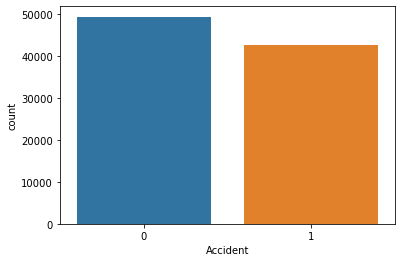

In [5]:
sns.countplot(x = 'Accident', data=df)

## I) Binary Classification

In [6]:
df = df[df.columns[~df.columns.isin([col for col in df.columns if col.startswith('Accident') and col != 'Accident'])]]

### a) Neural Network

**Create Input and Output Data**

In [7]:
X = df[df.columns[~df.columns.isin(['date', 'Accident', 'Unnamed: 0'])]]
y = df['Accident']

**Create train and test datasets**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Model Parameters**

In [9]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

**Define Custom Dataloaders**

In [10]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [11]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

**Define Neural Net Architecture**
<img src="https://miro.medium.com/max/1400/0*CLjAAd7s6o0yfEYZ.jpg"
     alt="NN"
     style="float: left; margin-right: 10px;" />

In [12]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 53.
        self.layer_1 = nn.Linear(53, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [13]:
model = binaryClassification()
device = torch.device('cpu')
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=53, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


**Train the model**

In [14]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

**Test the model**

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

**Classification Report**

In [ ]:
print(classification_report(y_test, y_pred_list))

### b) Random Forest

In [15]:
#output label
target = np.array(df['Accident'])

#input features
features = df[df.columns[~df.columns.isin(['date','Accident', 'Unnamed: 0'])]]
feature_list = list(features.columns)
features = np.array(features)

#split dataset into training and testing
train_features, test_features, train_target, test_target = train_test_split(features, 
target, test_size = 0.25, random_state = 10)


# Instantiate model with 100 decision trees
clf = RandomForestClassifier(n_estimators= 100)

# Train the model on training data
clf.fit(train_features, train_target)

predictions = clf.predict(test_features)
print("Accuracy:", metrics.accuracy_score(test_target, predictions))

#check contributions to prediction
feature_names = df.columns[~df.columns.isin(['date','Accident', 'Unnamed: 0'])]
feature_imp = pd.Series(clf.feature_importances_, index=feature_names.sort_values(ascending=False))
feature_imp

Accuracy: 0.7473176664784328


windchill                  0.063050
wind_speed_avg_10min       0.059489
wind_gust_max_10min        0.054295
wind_force_avg_10min       0.054394
wind_direction             0.054448
water_temperature          0.063421
water_level                0.062175
precipitation              0.062873
humidity                   0.011387
global_radiation           0.060041
dew_point                  0.125332
barometric_pressure_qfe    0.069320
air_temperature            0.049713
WeekDay_Wednesday          0.006474
WeekDay_Tuesday            0.008860
WeekDay_Thursday           0.018058
WeekDay_Sunday             0.006789
WeekDay_Saturday           0.006362
WeekDay_Monday             0.006597
Month_9.0                  0.002730
Month_8.0                  0.003379
Month_7.0                  0.003745
Month_6.0                  0.003907
Month_5.0                  0.003700
Month_4.0                  0.003490
Month_3.0                  0.003300
Month_2.0                  0.003833
Month_12.0                 0

## II) Mulit-Class Classification

**Notes:**
<br>
***a)***
<br>
Multi-class prediction for AccidentSeverity
<br>
***b)***
<br>
Multi-class prediction for AccidentType

### a) Neural Network

In [16]:
df = pd.read_csv('datasets/dataset.csv')

In [17]:
df.columns

Index(['Unnamed: 0', 'date', 'air_temperature', 'water_temperature',
       'wind_gust_max_10min', 'wind_speed_avg_10min', 'wind_force_avg_10min',
       'wind_direction', 'windchill', 'barometric_pressure_qfe',
       'precipitation', 'dew_point', 'global_radiation', 'humidity',
       'water_level', 'AccidentInvolvingPedestrian',
       'AccidentInvolvingBicycle', 'AccidentInvolvingMotorcycle', 'Accident',
       'AccidentType_at00', 'AccidentType_at1', 'AccidentType_at2',
       'AccidentType_at3', 'AccidentType_at4', 'AccidentType_at5',
       'AccidentType_at6', 'AccidentType_at7', 'AccidentType_at8',
       'AccidentType_at9', 'AccidentSeverityCategory_as2',
       'AccidentSeverityCategory_as3', 'AccidentSeverityCategory_as4',
       'WeekDay_Monday', 'WeekDay_Saturday', 'WeekDay_Sunday',
       'WeekDay_Thursday', 'WeekDay_Tuesday', 'WeekDay_Wednesday', 'Month_2.0',
       'Month_3.0', 'Month_4.0', 'Month_5.0', 'Month_6.0', 'Month_7.0',
       'Month_8.0', 'Month_9.0', 'Month_1

### b) Random Forest